# Multiclass Classification

In [327]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

def label_bcva(row): 
    final_bcva = row.target_va
    toRtn = 0
    if final_bcva < 60: 
        if final_bcva < 40: toRtn = 0
        else: toRtn = 1
    else:
        if final_bcva < 80: toRtn = 2
        else: toRtn = 3
    return toRtn

df = pd.read_csv("~/Documents/Github/paper/input/df_3_years.csv")
df['outcome'] = df.apply(lambda row: label_bcva(row), axis=1)

X, y = df.drop(columns=['target_va', 'outcome']), df.outcome.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4)

def score(model, X, y, cv=5, scoring='accuracy'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return np.mean(scores), np.std(scores)

## Logistic regression

In [328]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
score(lr, X, y)

(0.5423909423909423, 0.04505416977033754)

In [17]:
lr.fit(X_train, y_train)
preds = lr.predict(X_valid)
accuracy_score(y_valid, preds)

0.5641025641025641

In [18]:
lr.fit(X_train, y_train)
preds = lr.predict_proba(X_valid)
roc_auc_score(y_valid, preds, average="weighted", multi_class="ovr")

0.7420809909045203

## Random forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
score(rf, X, y)

(0.6914418914418914, 0.028919770470482862)

In [19]:
rf.fit(X_train, y_train)
preds = rf.predict(X_valid)
accuracy_score(y_valid, preds)

0.6666666666666666

In [20]:
rf.fit(X_train, y_train)
preds = rf.predict_proba(X_test)
roc_auc_score(y_test, preds, average="weighted", multi_class="ovr")

0.8835728323963619

## Gradient boosted classifier

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
score(gb, X, y)

(0.7250749250749251, 0.04025564984934498)

In [21]:
gb.fit(X_train, y_train)
preds = gb.predict(X_valid)
accuracy_score(y_valid, preds)

0.7692307692307693

In [22]:
gb.fit(X_train, y_train)
preds = gb.predict_proba(X_test)
roc_auc_score(y_test, preds, average="weighted", multi_class="ovr")

0.9369237625119978

## TabNet

In [29]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)

from matplotlib import pyplot as plt
%matplotlib inline

X, y = df.drop(columns=['target_va', 'outcome']).values, df.outcome.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4)

In [33]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
    verbose=0
)

In [34]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=1000, patience=100,
    batch_size=64
) 


Early stopping occurred at epoch 167 with best_epoch = 67 and best_valid_accuracy = 0.80769
Best weights from best epoch are automatically used!


In [37]:
preds = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds, y_true=y_valid,
                          average="weighted", multi_class="ovr")
valid_auc

0.9030568124685772

In [38]:
preds = clf.predict(X_valid)
accuracy_score(y_valid, preds)

0.8076923076923077

In [66]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_valid, preds)

array([[ 8,  1,  1,  0],
       [ 0,  7,  5,  0],
       [ 0,  1, 22,  5],
       [ 0,  0,  2, 26]])

# Probability distributions

## Single-year BCVA distribution

In [157]:
import os 
os.chdir('/Users/charlesoneill/Documents/GitHub/paper/results')

In [209]:
def return_tabnet():
    return TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
    verbose=0)

In [212]:
def train_tabnet(year):
    df = pd.read_csv(f"~/Documents/Github/paper/input/df_{year}_years.csv")
    df['outcome'] = df.apply(lambda row: label_bcva(row), axis=1)
    X, y = df.drop(columns=['target_va', 'outcome']).values, df.outcome.values
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4)
    clf = return_tabnet()
    clf.fit(X_train=X_train, y_train=y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_name=['train', 'valid'], max_epochs=1000, patience=100,
            batch_size=64)
    return clf

In [213]:
clf_1 = train_tabnet(1)
clf_2 = train_tabnet(2)
clf_3 = train_tabnet(3)
model_lst = [clf_1, clf_2, clf_3]


Early stopping occurred at epoch 222 with best_epoch = 122 and best_valid_accuracy = 0.83
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 171 with best_epoch = 71 and best_valid_accuracy = 0.79787
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 167 with best_epoch = 67 and best_valid_accuracy = 0.80769
Best weights from best epoch are automatically used!


In [260]:
def bcva_prob_dist(model, sample, year, ground_truth):
    t = [0, 30, 50, 70, 90, 100]
    preds_proba = model.predict_proba(sample).tolist()[0]
    preds_proba.insert(0, 0.0)
    preds_proba.append(0)
    plt.plot(t, preds_proba, color="orange")
    plt.fill_between(t, preds_proba, color="navy")
    plt.axvline(x=ground_truth, color='r', linestyle='-', label="True vision")
    plt.ylabel("Probability of BCVA")
    plt.xlabel(f"Vision at end of Year {year} (logMAR letters)")
    plt.legend()
    plt.savefig(f"year{year}_patient_distribution.png", dpi=300)
    plt.show()

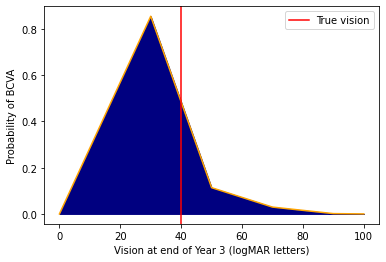

In [261]:
sample = X_valid[11:12]
bcva_prob_dist(clf, sample, 3, 40)

In [262]:
def get_three_years(patient_id, model_lst, plot=True):
    preds = []
    for i in range(1, 4):
        df = pd.read_csv(f"~/Documents/Github/paper/input/df_{i}_years.csv")
        df['outcome'] = df.apply(lambda row: label_bcva(row), axis=1)
        X = df.drop(columns=['target_va', 'outcome']).iloc[patient_id].values
        y = df.outcome.iloc[patient_id]
        ground_truth = df.target_va.iloc[patient_id]
        if plot: bcva_prob_dist(model_lst[i-1], [X], i, ground_truth)
        preds.append(model_lst[i-1].predict_proba([X]).tolist()[0])
    if not plot: return preds

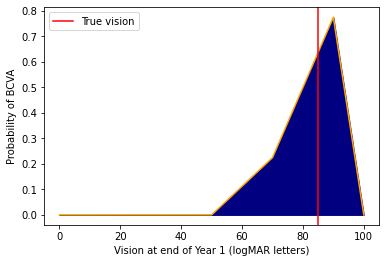

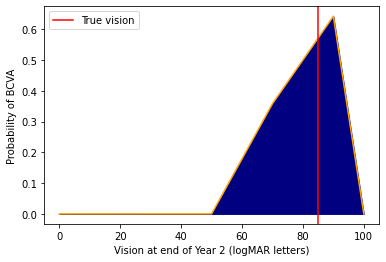

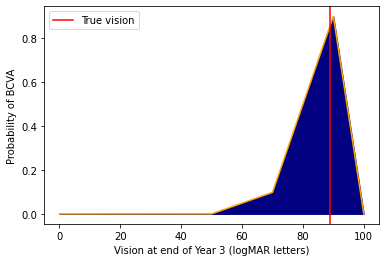

In [263]:
get_three_years(12, model_lst)

## Temporal BCVA distributions

In [241]:
preds = get_three_years(12, model_lst, plot=False)
preds

[[6.580825720448047e-05,
  0.00016460954793728888,
  0.22467590868473053,
  0.775093674659729],
 [0.00013951263099443167,
  0.0001286290498683229,
  0.3579482436180115,
  0.641783595085144],
 [0.0001351299142697826,
  9.594106086296961e-05,
  0.09832429885864258,
  0.9014445543289185]]

In [268]:
prob_to_vision(preds_ind(preds[0]))

90

In [278]:
def prob_to_vision(index): return 30 + (index*20)

def preds_to_scalar(preds): 
    toRtn = 0
    for i in range(3):
        toRtn += prob_to_vision(i) * preds[i]
    return toRtn

def temporal_prob_dist(preds):
    x, y_40, y_60, y_80, y_100 = [0,1,2,3], [0], [0], [0], 
    for i in range(3):
        index = preds[i].index(max(preds[i]))
        y.append(prob_to_vision(index))
    plt.bar(x, y)
    plt.ylim(0, 100)
    plt.ylabel("BCVA (logMAR letters)")
    plt.xlabel("Year")
    plt.show()
    return x, y

In [325]:
def prob(scalar): return np.ceil(scalar*100)

def temporal_prob_dist(preds):
    y_40, y_60, y_80, y_100 = [], [], [], [] 
    for i in range(3):
        y_40.append(prob(preds[i][0])), y_60.append(prob(preds[i][1]))
        y_80.append(prob(preds[i][2])), y_100.append(prob(preds[i][3]))
    df_plot = pd.DataFrame({"Below 40": y_40, "40-60": y_60,
                            "60-80": y_80, "80-100": y_100})
    df_plot[["Below 40", "40-60", "60-80", "80-100"]].plot(kind="bar", width = .35)
    ax = plt.gca()
    ax.set_xticklabels(("Year 1", "Year 2", "Year 3"))
    ax.set_ylabel("Probability of BCVA (%)")
    plt.savefig("temporal_patient_prob.png", dpi=300)
    plt.show()

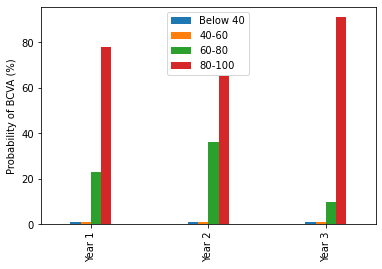

In [326]:
temporal_prob_dist(preds)